In [ ]:
### Name : Dimpal Pravin Phalak
### PRN : 20220802339


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Data Augmentation - Apply transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate by ±10 degrees
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Split Training Data (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Neural Network with Dropout
class RegularizedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, optimizer with L2 Regularization (weight_decay)
model = RegularizedNN()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
loss_fn = nn.CrossEntropyLoss()

# Early Stopping Setup
best_val_loss = float('inf')
patience = 5
counter = 0

# Training Loop with L1, L2 Regularization and Early Stopping
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # L1 Regularization (Manually adding absolute sum of weights)
        l1_lambda = 1e-5
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss/len(val_loader):.4f}")

# Testing the Model
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]


Epoch 1: Train Loss=0.7700, Val Loss=0.4214
Epoch 2: Train Loss=0.5604, Val Loss=0.3358
Epoch 3: Train Loss=0.5001, Val Loss=0.2932
Epoch 4: Train Loss=0.4744, Val Loss=0.2589
Epoch 5: Train Loss=0.4465, Val Loss=0.2321
Epoch 6: Train Loss=0.4346, Val Loss=0.2094
Epoch 7: Train Loss=0.4252, Val Loss=0.2216
Epoch 8: Train Loss=0.4200, Val Loss=0.1956
Epoch 9: Train Loss=0.4124, Val Loss=0.1999
Epoch 10: Train Loss=0.4011, Val Loss=0.1973
Epoch 11: Train Loss=0.3988, Val Loss=0.1979
Epoch 12: Train Loss=0.3972, Val Loss=0.1933
Epoch 13: Train Loss=0.3984, Val Loss=0.1960
Epoch 14: Train Loss=0.3899, Val Loss=0.1969
Epoch 15: Train Loss=0.3920, Val Loss=0.1719
Epoch 16: Train Loss=0.3825, Val Loss=0.1867
Epoch 17: Train Loss=0.3787, Val Loss=0.1771
Epoch 18: Train Loss=0.3803, Val Loss=0.1747
Epoch 19: Train Loss=0.3783, Val Loss=0.1691
Epoch 20: Train Loss=0.3754, Val Loss=0.1738
Test Accuracy: 91.81%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(device)

# 3. Define optimizer with L2 regularization (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2

# 4. Define loss function
criterion = nn.CrossEntropyLoss()

# 5. Train with L1 and L2 Regularization
epochs = 5
l1_lambda = 1e-5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L1 Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# 6. Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.95MB/s]


Epoch [1/5], Loss: 0.3855
Epoch [2/5], Loss: 0.2008
Epoch [3/5], Loss: 0.1640
Epoch [4/5], Loss: 0.1444
Epoch [5/5], Loss: 0.1315
Test Accuracy: 96.22%


In [ ]:
#Application: Housing Price Prediction with Regularization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.reshape(-1, 1)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Define model
class HousingNet(nn.Module):
    def __init__(self):
        super(HousingNet, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = HousingNet()

# L2 Regularization via weight_decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.MSELoss()

# L1 Regularization term
l1_lambda = 1e-4

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Add L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test)
    mse = criterion(preds, y_test)
    print(f"\nTest MSE: {mse.item():.4f}")


Epoch 1, Loss: 0.9709
Epoch 2, Loss: 0.4545
Epoch 3, Loss: 0.4212
Epoch 4, Loss: 0.4082
Epoch 5, Loss: 0.3941
Epoch 6, Loss: 0.3819
Epoch 7, Loss: 0.3603
Epoch 8, Loss: 0.3579
Epoch 9, Loss: 0.3479
Epoch 10, Loss: 0.3425
Epoch 11, Loss: 0.3456
Epoch 12, Loss: 0.3342
Epoch 13, Loss: 0.3295
Epoch 14, Loss: 0.3279
Epoch 15, Loss: 0.3325
Epoch 16, Loss: 0.3224
Epoch 17, Loss: 0.3197
Epoch 18, Loss: 0.3247
Epoch 19, Loss: 0.3189
Epoch 20, Loss: 0.3168
Epoch 21, Loss: 0.3154
Epoch 22, Loss: 0.3132
Epoch 23, Loss: 0.3106
Epoch 24, Loss: 0.3105
Epoch 25, Loss: 0.3133
Epoch 26, Loss: 0.3094
Epoch 27, Loss: 0.3073
Epoch 28, Loss: 0.3072
Epoch 29, Loss: 0.3064
Epoch 30, Loss: 0.3053
Epoch 31, Loss: 0.3047
Epoch 32, Loss: 0.3068
Epoch 33, Loss: 0.3032
Epoch 34, Loss: 0.3008
Epoch 35, Loss: 0.3038
Epoch 36, Loss: 0.3038
Epoch 37, Loss: 0.3023
Epoch 38, Loss: 0.3006
Epoch 39, Loss: 0.2994
Epoch 40, Loss: 0.2997
Epoch 41, Loss: 0.2988
Epoch 42, Loss: 0.3000
Epoch 43, Loss: 0.2987
Epoch 44, Loss: 0.29

Epoch 1, Train Loss: 1.1190, Val Loss: 0.5073
Epoch 2, Train Loss: 0.5472, Val Loss: 0.4430
Epoch 3, Train Loss: 0.5039, Val Loss: 0.4205
Epoch 4, Train Loss: 0.4754, Val Loss: 0.4024
Epoch 5, Train Loss: 0.4637, Val Loss: 0.4032
Epoch 6, Train Loss: 0.4425, Val Loss: 0.3830
Epoch 7, Train Loss: 0.4386, Val Loss: 0.3734
Epoch 8, Train Loss: 0.4264, Val Loss: 0.3797
Epoch 9, Train Loss: 0.4156, Val Loss: 0.3640
Epoch 10, Train Loss: 0.4150, Val Loss: 0.3539


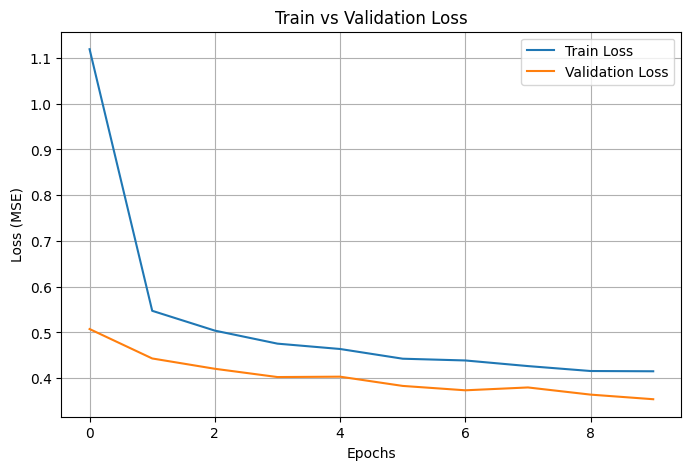

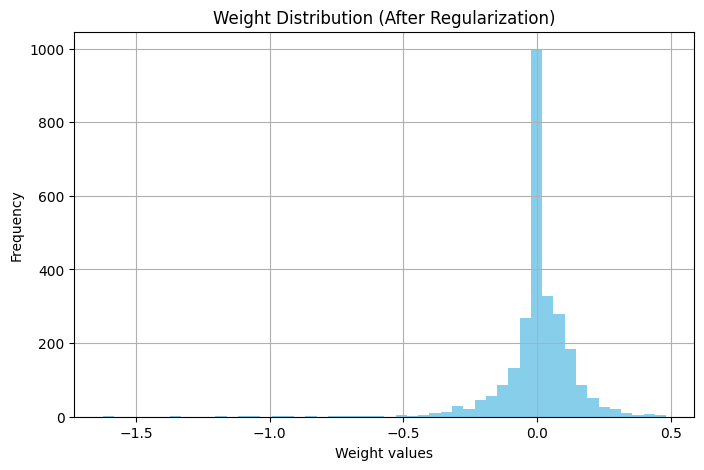

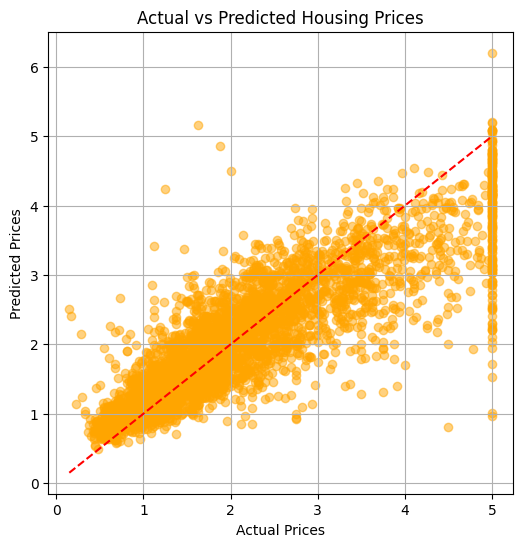

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.reshape(-1, 1)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Define model
class HousingNet(nn.Module):
    def __init__(self):
        super(HousingNet, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = HousingNet()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # L2 regularization
criterion = nn.MSELoss()
l1_lambda = 1e-4  # L1 regularization strength

# Track losses
train_losses = []
val_losses = []

# Train loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Add L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output, y_test)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# ────────────── GRAPH 1: Loss Curve ──────────────
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ────────────── GRAPH 2: Weight Distribution ──────────────
weights = []
for param in model.parameters():
    weights.extend(param.view(-1).detach().numpy())

plt.figure(figsize=(8,5))
plt.hist(weights, bins=50, color='skyblue')
plt.title("Weight Distribution (After Regularization)")
plt.xlabel("Weight values")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ────────────── GRAPH 3: Actual vs Predicted ──────────────
model.eval()
with torch.no_grad():
    predictions = model(X_test).detach().numpy()
    actual = y_test.detach().numpy()

plt.figure(figsize=(6,6))
plt.scatter(actual, predictions, alpha=0.5, color='orange')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.grid(True)
plt.show()


In [ ]:
# With Dataset:
#1. Regularization techniques (L1, L2, Dropout, Early Stopping) applied to neural networks.
#2. Overfitting reduced and validation performance improved.
#3. Dropout shown to increase model generalization.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


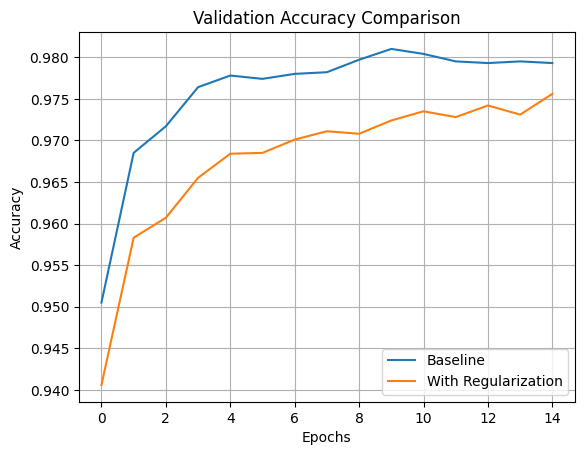

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 784) / 255.0, x_test.reshape(-1, 784) / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create models
def build_model(use_regularization=False):
    model = Sequential()
    if use_regularization:
        model.add(Dense(256, activation='relu', input_shape=(784,), kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.5))
    else:
        model.add(Dense(256, activation='relu', input_shape=(784,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train baseline model
baseline = build_model()
hist_base = baseline.fit(x_train, y_train, epochs=15, batch_size=128,
                         validation_data=(x_test, y_test), verbose=0)

# Train regularized model
regularized = build_model(use_regularization=True)
hist_reg = regularized.fit(x_train, y_train, epochs=15, batch_size=128,
                           validation_data=(x_test, y_test), verbose=0,
                           callbacks=[early_stop])

# Plot accuracy
plt.plot(hist_base.history['val_accuracy'], label='Baseline')
plt.plot(hist_reg.history['val_accuracy'], label='With Regularization')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Graphical Visualization:
#- Comparison plot of training vs validation accuracy.
#- Loss curves with and without regularization.
#- Visual impact of dropout represented with neuron activity plots.

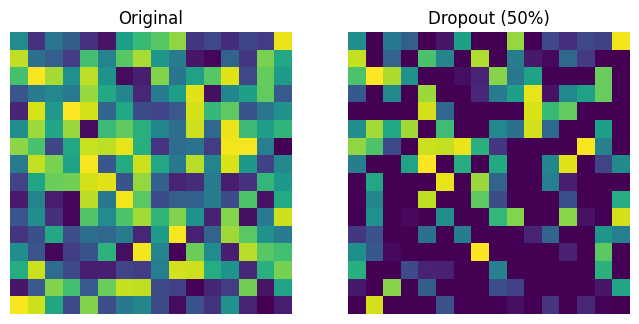

In [6]:
import numpy as np, matplotlib.pyplot as plt

def visualize_dropout_effect():
    act = np.random.rand(16, 16)
    drop = act * np.random.binomial(1, 0.5, act.shape)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    for i, data in enumerate([act, drop]):
        ax[i].imshow(data, cmap='viridis')
        ax[i].set_title(["Original", "Dropout (50%)"][i])
        ax[i].axis('off')
    plt.show()

visualize_dropout_effect()


In [ ]:
#Without Dataset:
#1. Overfit-prone synthetic data created.
#2. Model trained with and without regularization.
#3. Regularized model showed better performance on unseen samples.

In [ ]:
#Graphical Visualization:
#- Accuracy comparison bar chart.
#- Early stopping effectiveness visualized through validation curve.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


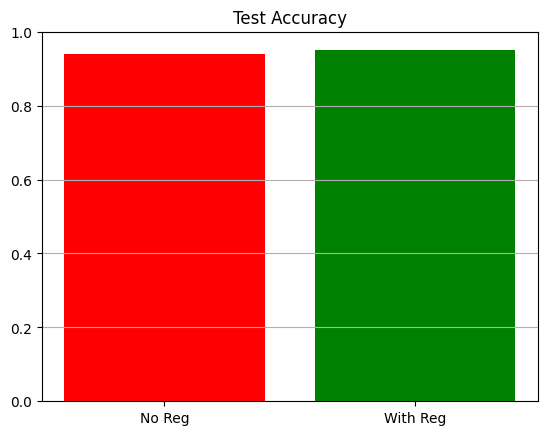

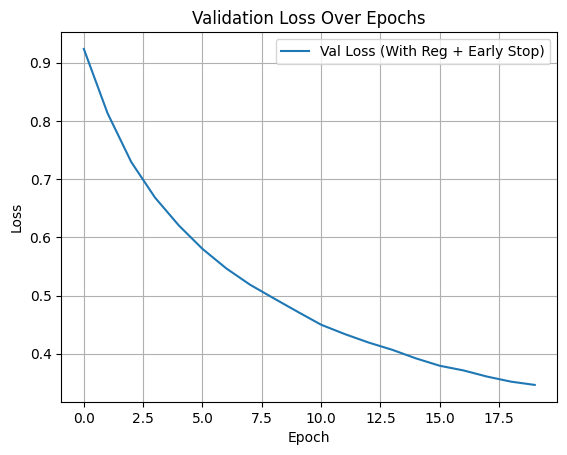

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# Synthetic binary classification data
X = np.random.randn(1000, 20)
y = (X @ np.random.randn(20) + np.random.randn(1000) > 0).astype(int)
y_cat = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

# Model builder
def make_model(reg=False):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(20,),
                    kernel_regularizer=l2(0.01) if reg else None))
    if reg: model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

base = make_model()
reg = make_model(reg=True)

h_base = base.fit(X_train, y_train, validation_split=0.2, epochs=20, verbose=0)
h_reg = reg.fit(X_train, y_train, validation_split=0.2, epochs=20, verbose=0, callbacks=[early_stop])

# Accuracy on test set
acc_base = accuracy_score(np.argmax(y_test, axis=1), np.argmax(base.predict(X_test), axis=1))
acc_reg = accuracy_score(np.argmax(y_test, axis=1), np.argmax(reg.predict(X_test), axis=1))

# 📊 Accuracy bar chart
plt.bar(['No Reg', 'With Reg'], [acc_base, acc_reg], color=['red', 'green'])
plt.title('Test Accuracy')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

# 📉 Early stopping effect
plt.plot(h_reg.history['val_loss'], label='Val Loss (With Reg + Early Stop)')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
